In [155]:
from datetime import timedelta, datetime, date as sysDate
import requests
import rapidjson
import time
import pandas as pd
import numpy as np
import asyncio
import aiohttp
import re
import numba
import os
import shutil
from termcolor import cprint
import psycopg2
from io import StringIO
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px

In [156]:
conn = psycopg2.connect("dbname=NHLFantasyPy user=postgres password=fantasy")
cur = conn.cursor()

In [157]:
df = pd.read_sql_query("SELECT * FROM game_logs;", conn)

In [158]:
#convert times to floats
def toi_to_min(toi):
    t = toi.split(":")
    t = list(map(int, t)) 
    if(len(t) < 2):
        return t[0]
    else:
        return t[0] * 60. + t[1]
    
df['eventimeonice'] = df['eventimeonice'].map(toi_to_min)
df['shorthandedtimeonice'] = df['shorthandedtimeonice'].map(toi_to_min)
df['powerplaytimeonice'] = df['powerplaytimeonice'].map(toi_to_min)

In [159]:
pd.DataFrame(data= {'key': list(df.keys()), 'dtype': list(df.dtypes)})

,key,dtype
0,split,int64
1,date,object
2,game,int64
3,player_id,int64
4,position,object
5,team_id,int64
6,opp_id,int64
7,ishome,bool
8,iswin,bool
9,isot,bool


In [160]:
# Group players based on average stats from all data
# First have to create a new df with avg values for each stat for each player (won't include fanpts bc it is linearly dependant)

In [161]:
player_ids = []
for id in list(df['player_id']):
    if id not in player_ids:
        player_ids.append(id)
player_ids[0:5]

[8471233, 8474056, 8475151, 8475179, 8470187]

In [162]:
avg_df = pd.DataFrame(columns = list(df.keys())[10:31])
avg_df

,fws,assists,goals,pim,shots,hits,powerplaypoints,shorthandedpoints,powerplaytimeonice,eventimeonice,...,gamewinninggoals,blocked,plusminus,shifts,shutouts,saves,shorthandedshots,evenshots,powerplayshots,goalsagainst


In [163]:
sub_df = df[list(avg_df.keys())]
for id in player_ids:
    avg_df = avg_df.append(sub_df[df['player_id'] == id].apply(np.mean, 0, True), ignore_index = True)

In [164]:
avg_df

,fws,assists,goals,pim,shots,hits,powerplaypoints,shorthandedpoints,powerplaytimeonice,eventimeonice,...,gamewinninggoals,blocked,plusminus,shifts,shutouts,saves,shorthandedshots,evenshots,powerplayshots,goalsagainst
0,9.408223,0.308370,0.177680,0.358297,1.606461,0.844347,0.124816,0.024963,132.077827,876.882526,...,0.019090,0.428781,-0.099853,24.339207,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001368,0.445964,0.146375,1.106703,2.454172,1.302326,0.254446,0.005472,206.259918,1117.874145,...,0.023256,1.365253,0.030096,28.088919,0.0,0.0,0.0,0.0,0.0,0.0
2,0.181034,0.291379,0.306897,0.520690,2.446552,1.393103,0.203448,0.003448,140.900000,785.612069,...,0.051724,0.496552,0.000000,20.217241,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.195860,0.050955,0.644904,1.195860,1.609873,0.065287,0.003185,85.800955,1020.062102,...,0.011146,1.332803,-0.082803,24.767516,0.0,0.0,0.0,0.0,0.0,0.0
4,0.004484,0.212257,0.073244,0.430493,2.164425,2.050822,0.047833,0.010463,53.263079,1031.005979,...,0.017937,1.895366,0.167414,24.932735,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,4.000000,0.000000,0.000000,1.000000,0.500000,1.000000,0.000000,0.000000,11.000000,646.500000,...,0.000000,0.000000,-0.500000,14.500000,0.0,0.0,0.0,0.0,0.0,0.0
795,0.000000,0.176471,0.176471,0.117647,1.529412,0.411765,0.058824,0.000000,81.529412,670.705882,...,0.000000,0.411765,-0.470588,17.235294,0.0,0.0,0.0,0.0,0.0,0.0
796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,3.0,2.0,1.0,1.0,1.0
797,0.090909,0.590909,0.272727,0.090909,2.045455,0.454545,0.045455,0.000000,214.818182,891.863636,...,0.045455,0.272727,0.227273,19.090909,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
pca = PCA(n_components=3)
X = np.array(avg_df)
pca.fit(X)

PCA(n_components=3)

In [166]:
print(pca.components_.shape)

(3, 21)


In [167]:
X = pca.transform(X)

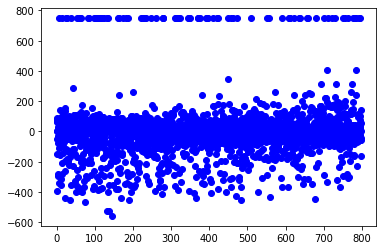

In [168]:
plt.plot(X, 'bo')

In [169]:
positions = []
for id in player_ids:
    positions.append(df[df['player_id'] == id]['position'].iloc[0])
positions[1:5]

['D', 'RW', 'D', 'D']

In [180]:
total_var = pca.explained_variance_ratio_.sum() * 100
components = pca.fit_transform(X)
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color = list(avg_df['saves']),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)

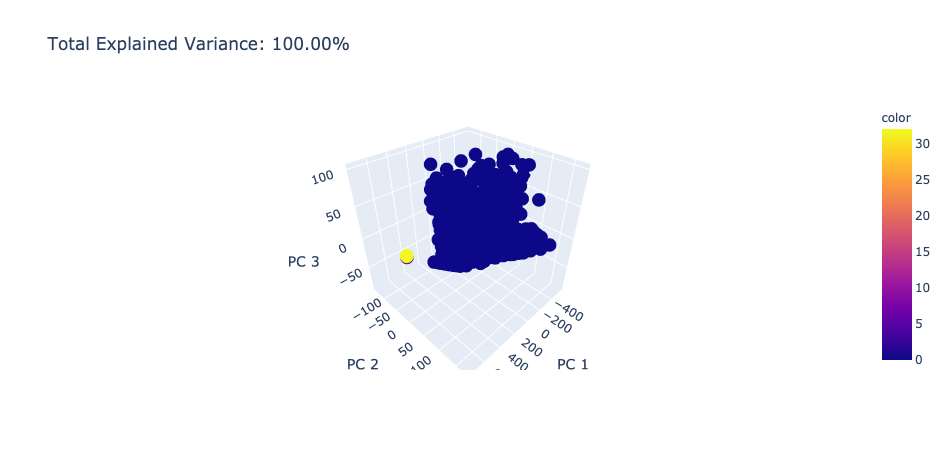

In [181]:
fig.show()

In [182]:
cur.close()
conn.close()
